# Estimating Pi with Monte Carlo Integration

## Introduction

In its simplest form, Monte Carlo integration approximates the value of a multidimensional integral of interest
\begin{equation}
    I = \int_{\Omega} f(\mathbf{x}) \; \mathrm{d}\mathbf{x}, \quad \text{where} \quad V = \int_{\Omega} \mathrm{d}\mathbf{x},
\end{equation}
with the sum
\begin{equation}
    I \approx Q_{N} := V \frac{1}{N} \sum_{i = 1}^{N} f(\mathbf{x}_{i}) = V \langle f \rangle,
\end{equation}
where the points $\mathbf{x}_{i}$ are uniformly sampled from $\Omega$.

Thus, we need to be able to:
* sample $\mathbf{x} \sim \Omega$ uniformly, and
* evaluate $f(\mathbf{x})$ for $\mathbf{x} \in \Omega$.

Then, the steps of the algorithm are:
1. Sample a given number $N$ of points $\mathbf{x}_{i}$ uniformly from $\Omega$.
2. Evaluate $f(\mathbf{x})$ at each of these points.
3. Obtain the average $\langle f \rangle$ and multiply by the volume $V$.

A paradigmatic example of this technique is the estimation of $\pi$.
Here, the integral of interest is
\begin{equation}
    I = \int_{\Omega} H(x, y) \; \mathrm{d}x \, \mathrm{d} y, \qquad
    H(x, y) =
    \left\{
    \begin{aligned}
        & 1 & & \text{if } x^{2} + y^{2} \leq 1 \\
        & 0 & & \text{else}
    \end{aligned}
    \right. \qquad \Omega = [-1, 1] \times [-1, 1]
\end{equation}
It is straightforward to show that $I = \pi$:
\begin{align}
    I = \int\limits_{-1}^{1} \int\limits_{-1}^{1} H(x, y) \; \mathrm{d}x \, \mathrm{d}y = \int\limits_{0}^{2 \pi} \mathrm{d} \phi \int\limits_{0}^{1} r \; \mathrm{d}r = \pi.
\end{align}
Therefore, approximating $I$ allows us to directly estimate the value of $\pi$.

Applying the algorithm above to this problem results in:
1. Sample points $(x, y)$ uniformly in the square $[-1, 1] \times [-1, 1]$.
2. Evaluate $H(x, y)$ in each of them, i.e., check if the point is at or within the unit circle.
3. Average the values of $H(x, y)$ and multiply by the volume $V = 4$.

## Setup

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
#take the rng as argument so that we have a fixed seed
def get_h_samples(num_samples: int, rng: np.random.Generator):
    points = 2. * rng.random(size=(num_samples, 2)) - 1.
    h_vals = (np.sum(points ** 2, axis=1) <= 1) * 1  # Multiply by 1 to “convert” to integer.
    return points, h_vals  # Return points just for illustrating the method.

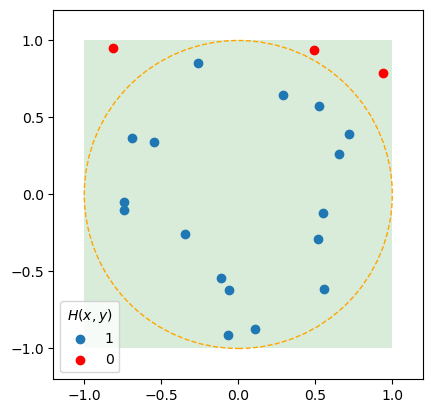

In [11]:
pts, h_samples = get_h_samples(num_samples=20, rng=np.random.default_rng(seed=42))

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(pts[h_samples == 1, 0], pts[h_samples == 1, 1], label="1")
ax.scatter(pts[h_samples == 0, 0], pts[h_samples == 0, 1], label="0", color='red')
ax.add_patch(plt.Rectangle((-1, -1), width=2, height=2, fc='green', alpha=0.15, zorder=-1))
ax.add_patch(plt.Circle(xy=(0, 0), radius=1, color='orange', zorder=0, fill=False, linestyle='--'))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal', 'box')
plt.legend(title=r"$H(x, y)$")
plt.show()

In [12]:
est_pi = 4 * np.mean(h_samples)
digits = int(np.round(-np.log10(np.abs(est_pi - np.pi)))) + 1  # Maximum amount of digits to display.
print(f"Estimated Pi: {est_pi:.{digits}f}")
print("Actual value:", np.pi)

Estimated Pi: 3.40
Actual value: 3.141592653589793


## Estimates vs number of the samples

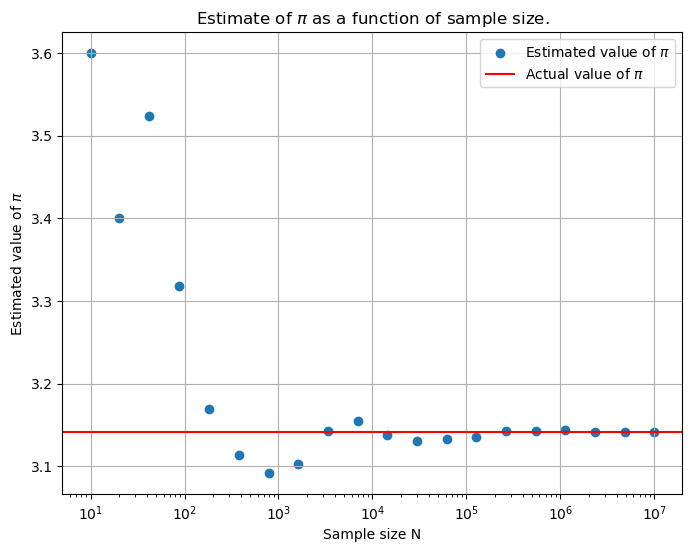

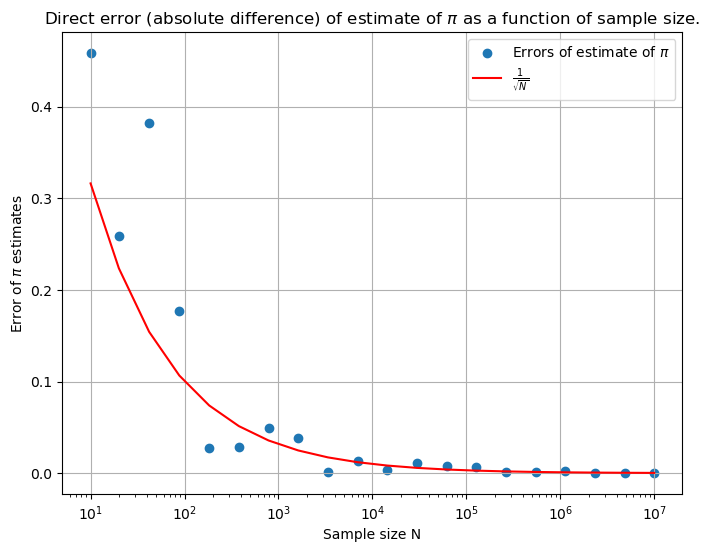

In [ ]:
# TODO: Plot the value of the estimates as a function of the sample size.
num_samples_list = np.logspace(1, 7, num=20, dtype = np.int64)
pi_values = []
for num_samples in num_samples_list: 
    pts, h_samples = get_h_samples(int(num_samples), rng=np.random.default_rng(seed=42))
    est_pi = 4 * np.mean(h_samples)
    pi_values.append(est_pi)

plt.figure(figsize=(8,6))
plt.title(r"Estimate of $\pi$ as a function of sample size.")
plt.scatter(num_samples_list, pi_values, label = r"Estimated value of $\pi$")
plt.xscale("log")
plt.axhline(y=np.pi, color='r', linestyle='-', label = r"Actual value of $\pi$")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Estimated value of $\pi$")
plt.legend()
plt.show()

# TODO: Plot the error of the estimates as a function of the sample size.
errors = [np.abs(np.pi - est_pi) for est_pi in pi_values]s
plt.figure(figsize=(8,6))
plt.title(r"Direct error (absolute difference) of estimate of $\pi$ as a function of sample size.")
plt.scatter(num_samples_list, errors, label = r"Errors of estimate of $\pi$")
one_over_sqrt_sample = [1/np.sqrt(x) for x in num_samples_list]
plt.plot(num_samples_list, one_over_sqrt_sample, color='r', linestyle='-', label = r"$\frac{1}{\sqrt{N}}$")
plt.xscale("log")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Error of $\pi$ estimates")
plt.legend()
plt.show()

## Estimating the error of the approximation

In this very simple scenario, we know the exact solution, so computing the error is trivial.
However, in real-life applications this is rarely the case.
This raises the question: **How confident can we be of our estimate?**

Since we do not know the exact solution, we do not know exactly how far off the estimate is from the true value, but we can _try to **estimate** the error as well_.
The simplest way to do this, is by using the unbiased estimate of the variance of the sum of observations:
\begin{equation}
    \begin{aligned}
        \text{Var}\left( \sum_{i = 1}^{N} f(\mathbf{x}_{i}) \right) & = \text{E}\left[ \left( \sum_{i = 1}^{N} f(\mathbf{x}_{i}) \right)^{2} \right] - \text{E}^{2}\left[ \sum_{i = 1}^{N} f(\mathbf{x}_{i}) \right] \\
        & = \sum_{i = 1}^{N} \left( \text{E}\left[f(\mathbf{x}_{i})^{2} \right] - \text{E}^{2}\left[ f(\mathbf{x}_{i})\right] \right) + \sum_{i = 1}^{N} \sum_{j \neq i}^{N} \left( \text{E}\left[ f(\mathbf{x}_{i}) f(\mathbf{x}_{j}) \right] - \text{E}[f(\mathbf{x}_{i})] \text{E}[f(\mathbf{x}_{j})] \right) \\
        & = \sum_{i = 1}^{N} \text{Var}(f(\mathbf{x}_{i})) + 2 \sum_{i = 1}^{N} \sum_{j \neq i}^{N} \text{Cov}(f(\mathbf{x}_{i}), f(\mathbf{x}_{j}))
    \end{aligned}
\end{equation}
If the observations $f(\mathbf{x}_{i})$ are independent and they all have the same variance (the variance of $f$ itself), this reduces to
\begin{equation}
    \text{Var}\left( \sum_{i = 1}^{N} f(\mathbf{x}_{i}) \right) = \sum_{i = 1}^{N} \text{Var}(f(\mathbf{x}_{i})) = N \, \text{Var}(f).
\end{equation}
Therefore, the variance of the estimate is
\begin{equation}
    \text{Var}(Q_{N}) = \text{Var}\left(\frac{V}{N} \left[ \sum_{i = 1}^{N} f(\mathbf{x}_{i}) \right] \right) = V^{2} \frac{\text{Var}(f)}{N},
\end{equation}
from which the error estimate follows as
\begin{equation}
    \delta Q_{N} \approx V \frac{\sigma_{f}}{\sqrt{N}}.
\end{equation}
This equation shows that the estimated error decreases as $1/\sqrt{N}$, _independently of the dimension of the problem._

With the insight gained from the error estimation, we can again plot the estimates and their associated error, and compare how they describe the exact value.

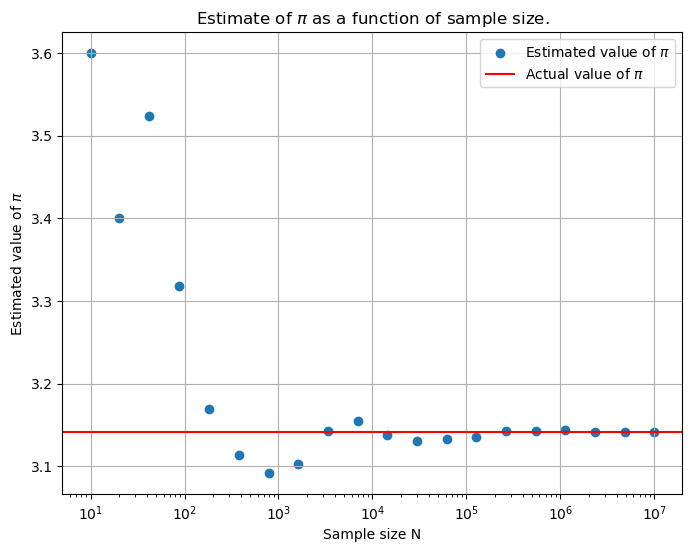

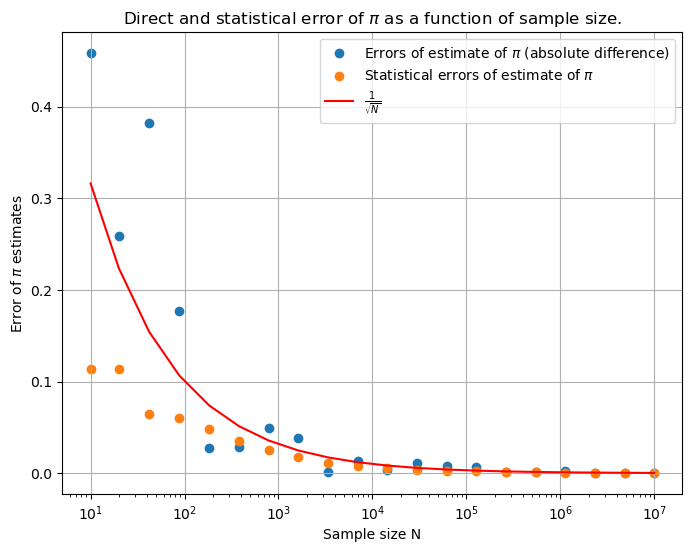

In [14]:
# TODO: Compute the statistical uncertainty for the estimates of pi at different sample sizes and add it to your previous plots.
num_samples_list = np.logspace(1, 7, num=20, dtype = np.int64)
pi_values = []
h_samples_list = []
volume = 4

for num_samples in num_samples_list: 
    pts, h_samples = get_h_samples(int(num_samples), rng=np.random.default_rng(seed=42))
    est_pi = 4 * np.mean(h_samples)
    pi_values.append(est_pi)
    h_samples_list.append(h_samples)

plt.figure(figsize=(8,6))
plt.title(r"Estimate of $\pi$ as a function of sample size.")
plt.scatter(num_samples_list, pi_values, label = r"Estimated value of $\pi$")
plt.xscale("log")
plt.axhline(y=np.pi, color='r', linestyle='-', label = r"Actual value of $\pi$")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Estimated value of $\pi$")
plt.legend()
plt.show()

errors = [np.abs(np.pi - est_pi) for est_pi in pi_values]
stat_errors = [np.var(h_samples)/np.sqrt(num_samples)*volume for h_samples, num_samples in zip(h_samples_list, num_samples_list)]
plt.figure(figsize=(8,6))
plt.title(r"Direct and statistical error of $\pi$ as a function of sample size.")
plt.scatter(num_samples_list, errors, label = r"Errors of estimate of $\pi$ (absolute difference)")
plt.scatter(num_samples_list, stat_errors, label = r"Statistical errors of estimate of $\pi$")
one_over_sqrt_sample = [1/np.sqrt(x) for x in num_samples_list]
plt.plot(num_samples_list, one_over_sqrt_sample, color='r', linestyle='-', label = r"$\frac{1}{\sqrt{N}}$")
plt.xscale("log")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Error of $\pi$ estimates")
plt.legend()
plt.show()

## Volume of a sphere

To wrap up: Extend this method to compute the volume of a sphere of radius $r$.
1. The domain of integration $\Omega$ is now a box. What is the volume $V$ in terms of $r$?
2. How is the function $S(x, y, z)$ defined?

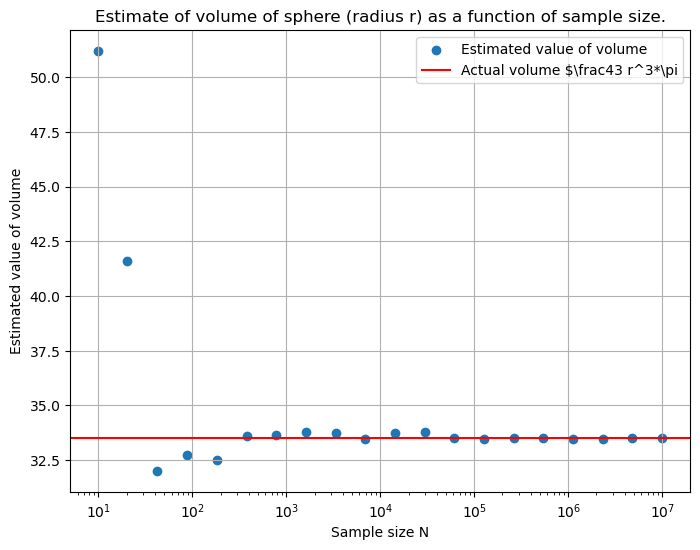

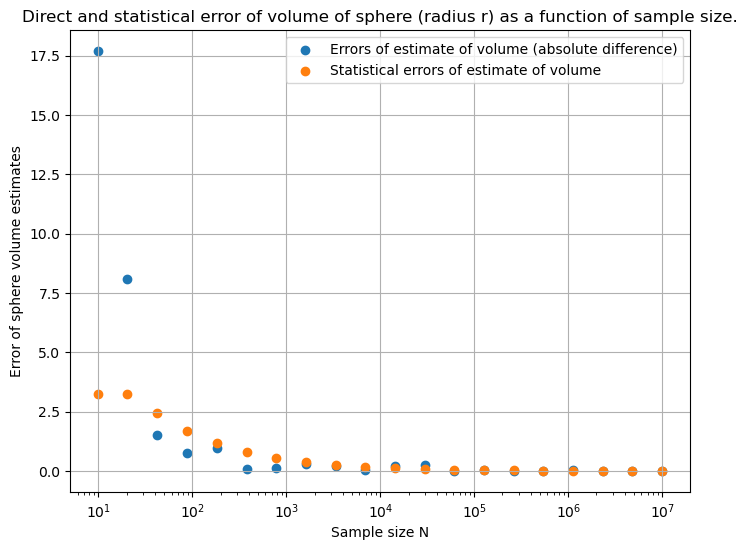

Using samples size of 1.0e+07 samples...
Best estimate of volume sphere with radius r = 2: 
33.510 $\pm$ 0.005 


In [15]:
# TODO: Obtain an estimate of the volume for r = 2, including the statistical uncertainty.
def get_h_samples_3d(num_samples: int, rng: np.random.Generator, radius: float):
    points = 2. * rng.random(size=(num_samples, 3)) - radius
    h_vals = (np.sum(points ** 2, axis=1) <= radius**2) * 1  # Multiply by 1 to “convert” to integer.
    return points, h_vals  # Return points just for illustrating the method.

# TODO: Compute the statistical uncertainty for the estimates of pi at different sample sizes and add it to your previous plots.
num_samples_list = np.logspace(1, 7, num=20, dtype = np.int64)
sphere_values = []
h_samples_list = []
radius = 2
volume = (radius*2)**3
true_val = (4/3)*radius**3*np.pi 

for num_samples in num_samples_list: 
    pts, h_samples = get_h_samples_3d(int(num_samples), rng=np.random.default_rng(seed=42), radius = radius)
    est_sphere = volume * np.mean(h_samples)
    sphere_values.append(est_sphere)
    h_samples_list.append(h_samples)

plt.figure(figsize=(8,6))
plt.title(r"Estimate of volume of sphere (radius r) as a function of sample size.")
plt.scatter(num_samples_list, sphere_values, label = r"Estimated value of volume")
plt.xscale("log")
plt.axhline(y=true_val, color='r', linestyle='-', label = r"Actual volume $\frac43 r^3*\pi")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Estimated value of volume")
plt.legend()
plt.show()

errors = [np.abs(true_val - est) for est in sphere_values]
stat_errors = [np.var(h_samples)/np.sqrt(num_samples)*volume for h_samples, num_samples in zip(h_samples_list, num_samples_list)]
plt.figure(figsize=(8,6))
plt.title(r"Direct and statistical error of volume of sphere (radius r) as a function of sample size.")
plt.scatter(num_samples_list, errors, label = r"Errors of estimate of volume (absolute difference)")
plt.scatter(num_samples_list, stat_errors, label = r"Statistical errors of estimate of volume")
one_over_sqrt_sample = [volume/np.sqrt(x) for x in num_samples_list]
plt.xscale("log")
plt.grid(True)
plt.xlabel("Sample size N")
plt.ylabel(r"Error of sphere volume estimates")
plt.legend()
plt.show()

best_estimate = sphere_values[-1]
best_stat_error = stat_errors[-1]
best_sample = num_samples_list[-1]
print(f"Using samples size of {best_sample:.1e} samples...")
print(f"Best estimate of volume sphere with radius r = {radius}: \n{best_estimate:.3f} $\\pm$ {best_stat_error:.3f} ")